## **Chest X-ray classification between Covid, pneumonia, normal using GoogleNet**

+ **About**: 
    + This notebook contains code to run experiments for paper: Covid-19 Chest X-ray classification and severity assessment using Convolutional and Transformer Neural Networks 

+ **Datasets**:
    + The COVID CXR dataset
    + The Chest Xray Pneumonia dataset 


+ **Classes**: 
    + Normal
    + Pneumonia
    + Covid_19

+ **Architecture**: 
    + Swin Transformer



In [1]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Windows-10-10.0.19043-SP0


In [2]:
three_classes_covid_xray_balanced = "/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/datasets/severity_dataset/joined_RALO_Brook/train"

In [3]:
print('> train_covidx9a_balance_9449 dir:', os.listdir(three_classes_covid_xray_balanced))

> train_covidx9a_balance_9449 dir: ['level1', 'level2']


## **Data Preparation**

### Read train_df

In [4]:
from tqdm import tqdm

train_image_dir = three_classes_covid_xray_balanced 
img_map = []

def prepareData(Dir, strat):
    cats = ["level1","level2"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
img_map_covidx9a = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 1901/1901 [00:00<00:00, 377920.75it/s]


In [5]:
img_map_covidx9a.head()

,path,label
2402,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level2
418,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
1516,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level2
106,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
441,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1


### Read test_df

In [6]:
from tqdm import tqdm

test_image_dir = "/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/datasets/severity_dataset/joined_RALO_Brook/test/"

img_map = []

def prepareData(Dir, strat):
    cats = ["level1", "level2"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(test_image_dir,'train')
test_img_map_covidx9a = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 98/98 [00:00<00:00, 100844.40it/s]


### Images Visualization

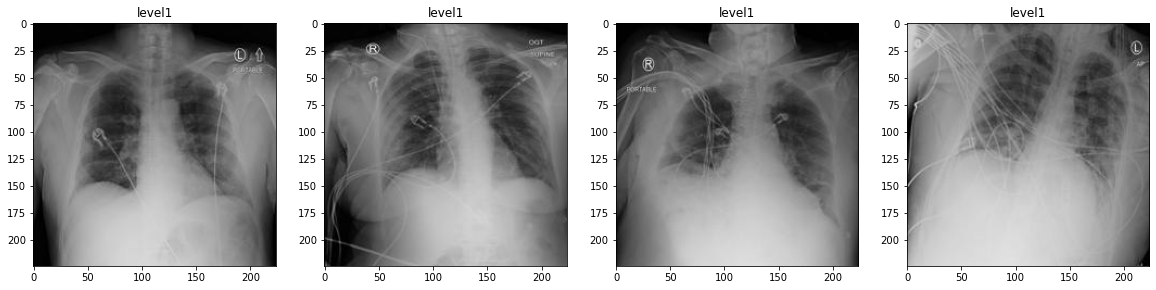

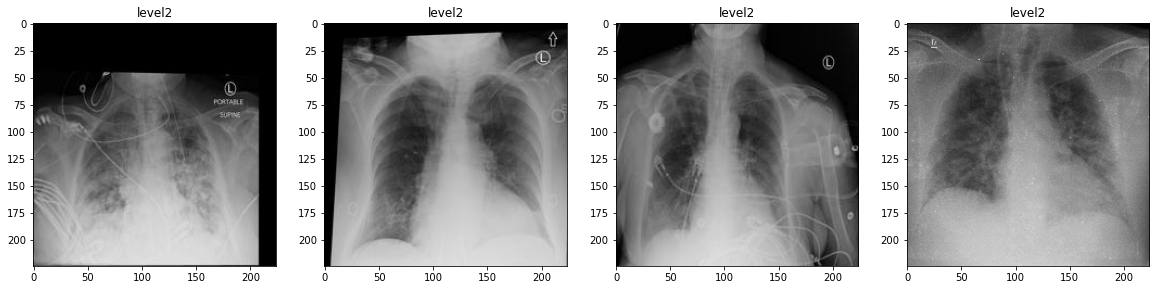

In [7]:
import matplotlib.pyplot as plt

def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
print_images(img_map_covidx9a[img_map_covidx9a['label']=="level1"].iloc[0:4])
print_images(img_map_covidx9a[img_map_covidx9a['label']=="level2"].iloc[0:4])
#print_images(img_map_covidx9a[img_map_covidx9a['label']=="COVID-19"].iloc[0:4])

%matplotlib inline

In [8]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_map_covidx9a)
print(label_count)

level2    1901
level1    1231
dtype: int64


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_map_covidx9a['path'].to_numpy()
labels = img_map_covidx9a['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=73)

In [10]:
for train_index, val_index in stratified_sample.split(features, labels):
    X_train, val_X = features[train_index], features[val_index]
    y_train, val_y = labels[train_index], labels[val_index]
    
half_size = np.int(len(val_X))
X_val, y_val = val_X[0:half_size], val_y[0:half_size]

C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_1216/2451442638.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  half_size = np.int(len(val_X))


In [11]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

In [12]:
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [13]:
# data summary
print('> {} train size'.format(X_train.shape[0]))
print('> {} val size'.format(X_val.shape[0]))

> 2505 train size
> 627 val size


In [14]:
train_map.head()

,path,label
0,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
1,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
2,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level2
3,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1
4,/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...,level1


### Data Augmentation

In [15]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
#IMG_SIZE = 224
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("level1", "level2")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['level1', 'level2']


In [16]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [17]:
batch_size = 2

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

### Get train_generator

In [18]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 2505 validated image filenames belonging to 2 classes.
> label count for train set


level2    1520
level1     985
dtype: int64

### Get test_generator

In [19]:
test_generator = get_generator(test_img_map_covidx9a)

print('> label count for test set')
getLabelCount(test_img_map_covidx9a)

Found 150 validated image filenames belonging to 2 classes.
> label count for test set


level2    98
level1    52
dtype: int64

### Get val_generator

In [20]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 627 validated image filenames belonging to 2 classes.
> label count for val set


level2    381
level1    246
dtype: int64

In [21]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


## **Model Construction**

In [22]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'
n_classes = len(CATEGORIES)
print('> {} classes'.format(n_classes))

> 2 classes


In [23]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    
    model = Model(inputs = baseModel.input, outputs = headModel)
    return model

### Build Swin Transformer

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization, GlobalAveragePooling1D

CFGS = {
    'swin_tiny_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24]),
    'swin_small_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24]),
    'swin_base_224': dict(input_size=(224, 224), window_size=7, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_base_384': dict(input_size=(384, 384), window_size=12, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_large_224': dict(input_size=(224, 224), window_size=7, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48]),
    'swin_large_384': dict(input_size=(384, 384), window_size=12, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48])
}


class Mlp(tf.keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., prefix=''):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Dense(hidden_features, name=f'{prefix}/mlp/fc1')
        self.fc2 = Dense(out_features, name=f'{prefix}/mlp/fc2')
        self.drop = Dropout(drop)

    def call(self, x):
        x = self.fc1(x)
        x = tf.keras.activations.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    B, H, W, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=[-1, H // window_size,
                   window_size, W // window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    x = tf.reshape(windows, shape=[-1, H // window_size,
                   W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x


class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., prefix=''):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.prefix = prefix

        self.qkv = Dense(dim * 3, use_bias=qkv_bias,
                         name=f'{self.prefix}/attn/qkv')
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name=f'{self.prefix}/attn/proj')
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(f'{self.prefix}/attn/relative_position_bias_table',
                                                            shape=(
                                                                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :,
                                         None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).astype(np.int64)
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(
            relative_position_index), trainable=False, name=f'{self.prefix}/attn/relative_position_index')
        self.built = True

    def call(self, x, mask=None):
        B_, N, C = x.get_shape().as_list()
        qkv = tf.transpose(tf.reshape(self.qkv(
            x), shape=[-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ tf.transpose(k, perm=[0, 1, 3, 2]))
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(
            self.relative_position_index, shape=[-1]))
        relative_position_bias = tf.reshape(relative_position_bias, shape=[
                                            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=[2, 0, 1])
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]  # tf.shape(mask)[0]
            attn = tf.reshape(attn, shape=[-1, nW, self.num_heads, N, N]) + tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32)
            attn = tf.reshape(attn, shape=[-1, self.num_heads, N, N])
            attn = tf.nn.softmax(attn, axis=-1)
        else:
            attn = tf.nn.softmax(attn, axis=-1)

        attn = self.attn_drop(attn)

        x = tf.transpose((attn @ v), perm=[0, 2, 1, 3])
        x = tf.reshape(x, shape=[-1, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def drop_path(inputs, drop_prob, is_training):
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)


class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path_prob=0., norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        self.prefix = prefix

        self.norm1 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm1')
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, prefix=self.prefix)
        self.drop_path = DropPath(
            drop_path_prob if drop_path_prob > 0. else 0.)
        self.norm2 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm2')
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       drop=drop, prefix=self.prefix)

    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            img_mask = tf.convert_to_tensor(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(
                mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(
                initial_value=attn_mask, trainable=False, name=f'{self.prefix}/attn_mask')
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=[-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=[-1, self.window_size * self.window_size, C])

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = tf.reshape(
            attn_windows, shape=[-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[
                        self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, shape=[-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, input_resolution, dim, norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = Dense(2 * dim, use_bias=False,
                               name=f'{prefix}/downsample/reduction')
        self.norm = norm_layer(epsilon=1e-5, name=f'{prefix}/downsample/norm')

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = tf.reshape(x, shape=[-1, H, W, C])

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat([x0, x1, x2, x3], axis=-1)
        x = tf.reshape(x, shape=[-1, (H // 2) * (W // 2), 4 * C])

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path_prob=0., norm_layer=LayerNormalization, downsample=None, use_checkpoint=False, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = tf.keras.Sequential([SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                           num_heads=num_heads, window_size=window_size,
                                           shift_size=0 if (
                                               i % 2 == 0) else window_size // 2,
                                           mlp_ratio=mlp_ratio,
                                           qkv_bias=qkv_bias, qk_scale=qk_scale,
                                           drop=drop, attn_drop=attn_drop,
                                           drop_path_prob=drop_path_prob[i] if isinstance(
                                               drop_path_prob, list) else drop_path_prob,
                                           norm_layer=norm_layer,
                                           prefix=f'{prefix}/blocks{i}') for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer, prefix=prefix)
        else:
            self.downsample = None

    def call(self, x):
        x = self.blocks(x)

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class PatchEmbed(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), patch_size=(4, 4), in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__(name='patch_embed')
        patches_resolution = [img_size[0] //
                              patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = Conv2D(embed_dim, kernel_size=patch_size,
                           strides=patch_size, name='proj')
        if norm_layer is not None:
            self.norm = norm_layer(epsilon=1e-5, name='norm')
        else:
            self.norm = None

    def call(self, x):
        B, H, W, C = x.get_shape().as_list()
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = tf.reshape(
            x, shape=[-1, (H // self.patch_size[0]) * (W // self.patch_size[0]), self.embed_dim])
        if self.norm is not None:
            x = self.norm(x)
        return x


class SwinTransformerModel(tf.keras.Model):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', include_top=False,
                 img_size=(224, 224), patch_size=(4, 4), in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=LayerNormalization, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__(name=model_name)

        self.include_top = include_top

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute postion embedding
        if self.ape:
            self.absolute_pos_embed = self.add_weight('absolute_pos_embed',
                                                      shape=(
                                                          1, num_patches, embed_dim),
                                                      initializer=tf.initializers.Zeros())

        self.pos_drop = Dropout(drop_rate)

        # stochastic depth
        dpr = [x for x in np.linspace(0., drop_path_rate, sum(depths))]

        # build layers
        self.basic_layers = tf.keras.Sequential([BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                                  patches_resolution[1] // (2 ** i_layer)),
                                                depth=depths[i_layer],
                                                num_heads=num_heads[i_layer],
                                                window_size=window_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path_prob=dpr[sum(depths[:i_layer]):sum(
                                                    depths[:i_layer + 1])],
                                                norm_layer=norm_layer,
                                                downsample=PatchMerging if (
                                                    i_layer < self.num_layers - 1) else None,
                                                use_checkpoint=use_checkpoint,
                                                prefix=f'layers{i_layer}') for i_layer in range(self.num_layers)])
        self.norm = norm_layer(epsilon=1e-5, name='norm')
        self.avgpool = GlobalAveragePooling1D()
        if self.include_top:
            self.head = Dense(num_classes, name='head')
        else:
            self.head = None

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        x = self.basic_layers(x)
        x = self.norm(x)
        x = self.avgpool(x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        if self.include_top:
            x = self.head(x)
        return x


def SwinTransformer(model_name='swin_tiny_224', num_classes=1000, include_top=True, pretrained=True, use_tpu=False, cfgs=CFGS):
    cfg = cfgs[model_name]
    net = SwinTransformerModel(
        model_name=model_name, include_top=include_top, num_classes=num_classes, img_size=cfg['input_size'], window_size=cfg[
            'window_size'], embed_dim=cfg['embed_dim'], depths=cfg['depths'], num_heads=cfg['num_heads']
    )
    net(tf.keras.Input(shape=(cfg['input_size'][0], cfg['input_size'][1], 3)))
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_ckpt = tf.keras.utils.get_file(
            model_name, url, untar=True)
    else:
        pretrained_ckpt = pretrained

    if pretrained_ckpt:
        if tf.io.gfile.isdir(pretrained_ckpt):
            pretrained_ckpt = f'{pretrained_ckpt}/{model_name}.ckpt'

        if use_tpu:
            load_locally = tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost')
            net.load_weights(pretrained_ckpt, options=load_locally)
        else:
            net.load_weights(pretrained_ckpt)

    return net

In [25]:
IMAGE_SIZE=[224, 224]
CLASSES = ['level1', 'level2']

def load_swin_transformer():
    img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"), input_shape=[*IMAGE_SIZE, 3])
    pretrained_model = SwinTransformer('swin_base_224', num_classes=len(CLASSES), include_top=False, pretrained=True, use_tpu=True)
    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    return model

load_swin_transformer().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
swin_base_224 (SwinTransform (None, 1024)              87079364  
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 87,081,414
Trainable params: 86,745,274
Non-trainable params: 336,140
_________________________________________________________________


### Get metrics

In [26]:
def getMetrics(name, type_):
    if name == 'GoogLeNet':
        if type_ == 'accuracy':
            return 'output3_accuracy'
        if type_ == 'loss':
            return 'output3_loss'
        if type_ == 'val_accuracy':
            return 'val_output3_accuracy'
        if type_ == 'val_loss':
            return 'val_output3_loss'
    else:
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

## **Setting Call Backs**

In [27]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
          
EPOCHS = 120
patience = 10

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
        
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics(name,'accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics(name, 'val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath = name + '_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics(name, 'val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]

GoogLeNet_callbacks = getCallbacks('GoogLeNet')
SwinTransformer_callbacks = getCallbacks('SwinTransformer')
callbacks = getCallbacks('DenseNet121')
Hybrid_callbacks = getCallbacks('HybridTransformer') 
InceptionNet_callbacks = getCallbacks('InceptionNet')
DOLG_callbacks = getCallbacks('DOLGNet')

## **Compile Model**

In [28]:
from tensorflow_addons import optimizers as tfa_optimizers

def CompileModel(name, model):
    if name == 'GoogLeNet':
        model.compile(optimizer='adam', loss=entropy, metrics={"output1":"accuracy", "output2":"accuracy", "output3":"accuracy"})
    else:
        model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    return model

def FitModel(model, name):
    callbacks_ = callbacks
    if name == 'SwinTransformer':
        callbacks_ = SwinTransformer_callbacks
    if name == 'GoogLeNet':
        callbacks_ = GoogLeNet_callbacks
    if name == 'HybridTransformer':
        callbacks_ = Hybrid_callbacks
    if name == 'InceptionNet':
        callbacks_ = InceptionNet_callbacks
    if name == 'DOLGNet':
        callbacks_ = DOLG_callbacks
    history = model.fit(train_generator, 
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights(name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]
    
    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

In [36]:
def BuildModel(name):
    if name == 'GoogLeNet':
        prepared_model = load_GoogLeNet() 
    if name == 'DenseNet121':
        prepared_model = load_DenseNet121()
    if name == 'SwinTransformer':
        prepared_model = load_swin_transformer()
    if name == 'HybridTransformer':
        prepared_model = load_hybrid_swin_transformer()
    if name == 'InceptionNet':
        prepared_model = load_inception_net()
    if name == 'DOLGNet':
        prepared_model = load_DOLG_net()
    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

## **Training Swin Transformer**

In [37]:
s_compiled_model = BuildModel('SwinTransformer')
s_model, s_history = FitModel(s_compiled_model, 'SwinTransformer')

Epoch 1/120
31/31 [==============================] - 38s 313ms/step - loss: 0.7397 - accuracy: 0.5469 - val_loss: 0.6082 - val_accuracy: 0.6875

Epoch 00001: val_loss did not improve from 0.59630
Epoch 2/120
31/31 [==============================] - 5s 165ms/step - loss: 0.6947 - accuracy: 0.5938 - val_loss: 0.6154 - val_accuracy: 0.6875

Epoch 00002: val_loss did not improve from 0.59630
Epoch 3/120
31/31 [==============================] - 5s 166ms/step - loss: 0.7149 - accuracy: 0.6094 - val_loss: 0.9085 - val_accuracy: 0.3125

Epoch 00003: val_loss did not improve from 0.59630
Epoch 4/120
31/31 [==============================] - 5s 168ms/step - loss: 0.7311 - accuracy: 0.5781 - val_loss: 0.6574 - val_accuracy: 0.6875

Epoch 00004: val_loss did not improve from 0.59630
Epoch 5/120
31/31 [==============================] - 5s 168ms/step - loss: 0.7230 - accuracy: 0.6719 - val_loss: 0.6341 - val_accuracy: 0.6875

Epoch 00005: val_loss did not improve from 0.59630
Epoch 6/120
31/31 [=====

## **Model Evaluation on the TestSet**

In [38]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [32]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def test_set_results(pred_value, n=1):    
    y_test = test_generator.labels
    X_test, _ = test_generator.next()
    
    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()
    
    n_correct = np.int(corr_pred[0][0] + corr_pred[1][1]) # + corr_pred[2][2]
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [33]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [34]:
def model_summary(model, history, name):
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('Best Epochs: ', index)
    
    if name == 'GoogLeNet':
        results = model.evaluate(test_generator, verbose=1)
        loss, output3_loss, output1_loss, output2_loss, output3_accuracy, output1_accuracy, output2_accuracy = results
        
        for i in range(3):
            n = i + 1
            out_layer = 'Output Layer {}'.format(n)
            
            if n == 1:
                test_accuracy = output1_accuracy
                test_loss = output1_loss

            if n == 2:
                test_accuracy = output2_accuracy
                test_loss = output2_loss
                
            if n == 3:
                test_accuracy = output3_accuracy
                test_loss = output3_loss
                
                
            output_name = 'output{}_'.format(n)
            train_accuracy, train_loss = history.history[output_name + 'accuracy'][index], history.history[output_name + 'loss'][index]
            
  
            print_graph(output_name + 'loss', index, history)
            print_graph(output_name + 'accuracy', index, history)
        
            print('---'*15)  
            print('GoogLeNet Dense output {}:'.format(n))
            
            print('> Accuracy on train :'.format(out_layer), train_accuracy, 
                  '\tLoss on train:',train_loss)
        
            print('> Accuracy on test :'.format(out_layer), test_accuracy,
                  '\tLoss on test:',test_loss)
            
            print('---'*15)
            print('> predicting test')
            print('---'*15)
            
            predictions = model.predict(test_generator, verbose=1)
            preds = np.argmax(predictions[i], axis=1)
            test_set_results(preds, n)
                
    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
        
        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        
        print('---'*15) 
        print(name)
        print('> Accuracy on train:',train_accuracy, 
              '\tLoss on train:',train_loss)
        
        print('> Accuracy on test:',test_accuracy,
              '\tLoss on test:',test_loss)
        
        print('---'*15)
        print('> predicting test')
        print('---'*15)
        
        printResults(name, model)

## **Swin Transformer Results**

Best Epochs:  0
75/75 [==============================] - 13s 174ms/step - loss: 0.6585 - accuracy: 0.6533


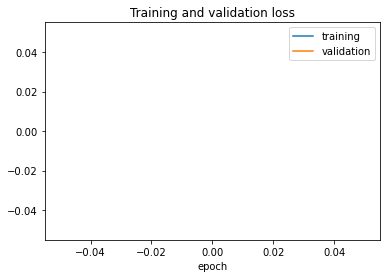

<Figure size 432x288 with 0 Axes>

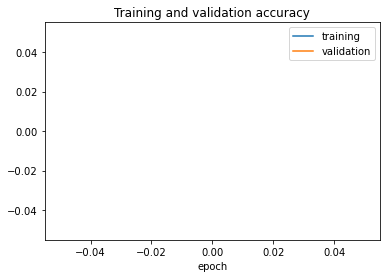

---------------------------------------------
SwinTransformer
> Accuracy on train: 0.71875 	Loss on train: 0.6121219992637634
> Accuracy on test: 0.653333306312561 	Loss on test: 0.6585493087768555
---------------------------------------------
> predicting test
---------------------------------------------
75/75 [==============================] - 17s 161ms/step


<Figure size 432x288 with 0 Axes>

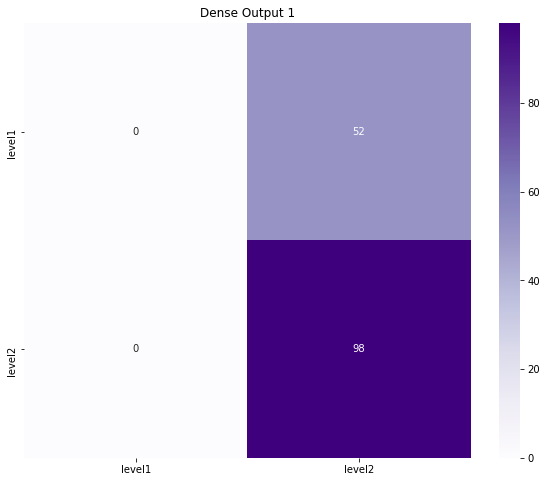

.............................................
> Correct Predictions: 98
> Wrong Predictions: 52
.............................................
              precision    recall  f1-score   support

      level1       0.00      0.00      0.00        52
      level2       0.65      1.00      0.79        98

    accuracy                           0.65       150
   macro avg       0.33      0.50      0.40       150
weighted avg       0.43      0.65      0.52       150



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_1216/3032867848.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1]) # + corr_pred[2][2]
C:\Users\MCSP_Lab\anaconda3\envs\python-3-9\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MCSP_Lab\anaconda3\

In [35]:
model_summary(s_model, s_history, 'SwinTransformer')